# If Fitting with GA
**Written by Akwasi Darkwah Akwaboah**<br>
**01/20/2020**



***Clamping Protocol***

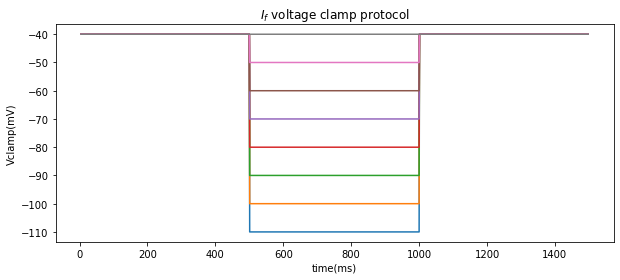

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vcm = np.arange(-110, -39, 10)
Vhold = -40  #mV
dt = 1  # time step
tStart = 0
tEnd = 1500
nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
Vm = np.zeros((nStep + 1, 1), dtype=np.float)
plot_time = np.empty((nStep, 1), dtype=np.float)
plot_Vm = np.empty((nStep, len(Vcm)), dtype=np.float)
t = np.linspace(tStart, tEnd, nStep + 1)
i = 0  #column selector

for Vc in Vcm:
    tNow = tStart
    Vm[0] = Vhold
    for iStep in np.arange(nStep):
            Vm[iStep+1] = (0 < tNow < 500)* Vhold + (500 <= tNow < 1000 )*Vc + (tNow >= 1000 )*Vhold
            plot_Vm[iStep, i] = Vm[iStep]
            plot_time[iStep] = tNow
            tNow = tStart + iStep * dt
    i = i + 1 #increment to next clamp column

plt.figure(figsize = (10,4))
plt.plot(plot_time[5:], plot_Vm[5:])
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{f}$ voltage clamp protocol')
#plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='lower left')

#plt.grid()
plt.show()

**If function and initial stewart model plot**

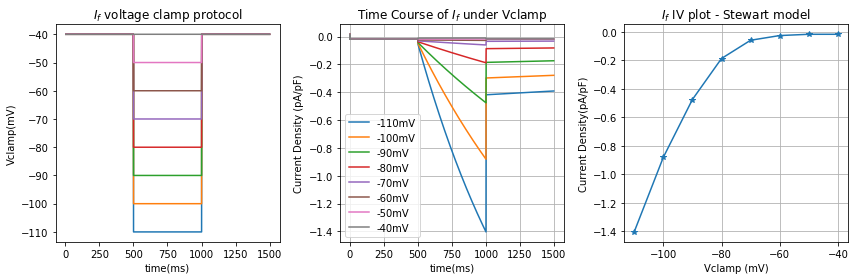

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#If function 
def If_func(Gfk, Gfna, ayss, byss, cyss, a_ay, b_ay, a_by, b_by, a_tau):
    #constants
    dt = 1 #time steps
    tStart = 0
    tEnd = 1500
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    t = np.linspace(tStart, tEnd, nStep + 1)
    Vcm = np.arange(-110, -39, 10)
    Vhold = -50  #mV
    
    K_o = 5.4 #mM
    Na_o = 140 #mM

    K_i = 136.9896086978 #mM
    Na_i = 8.5447311020  #mM
    R = 8.314 #J K^-1 mol^-1
    T = 310 #K
    F = 96.4867 #C.mmol^-1
    Gfk = 0.0234346
    Gfna = 0.0145654
    Cmem = 1.38e-10

    Ek = ((R*T)/F)*np.log(K_o/K_i)
    Ena = ((R*T)/F)*np.log(Na_o/Na_i)

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    plot_y = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_y = np.zeros((nStep, len(Vcm)), dtype=np.float)

    plot_If = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)
    i = 0 #column counter

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vhold
        # initial condition
        y = 0.0184308075
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (0 < tNow < 500)* Vhold + (500 <= tNow < 1000 )*Vc + (tNow >= 1000 )*Vhold
            yss = ayss/(1 + np.exp((Vm[iStep] + byss)/cyss))
            alpha_y = np.exp(-(a_ay + (b_ay*Vm[iStep])))
            beta_y = np.exp(a_by + (b_by*Vm[iStep]))
            tau_y = a_tau/(alpha_y + beta_y)
            dy = ((yss - y)/ tau_y)*dt

            if_k = Gfk * y * (Vm[iStep] - Ek)
            if_na = Gfna * y * (Vm[iStep] - Ena)
            If = if_k + if_na
            Im = If + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_y[iStep, i] = y
            plot_If[iStep, i] = If
            plot_tau_y[iStep, i] = tau_y
            plot_time[iStep] = tNow
            plot_Im[iStep] = Im

            y = y+dy
            tNow = tStart + iStep * dt
        i = i + 1
    If_peaks = np.min(plot_If, axis=0)
    return If_peaks, plot_time, plot_If

Vcm = np.arange(-110, -39, 10)
If_pks, time, plt_If = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)
fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(plot_time[5:], plot_Vm[5:])
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{f}$ voltage clamp protocol')
#plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='lower left')
#plt.grid()
#plt.show()


plt.subplot(1,3,3)
plt.plot(Vcm, If_pks, '-*')
plt.xlabel('Vclamp (mV)')
plt.ylabel('Current Density(pA/pF)')
plt.title('$I_f$ IV plot - Stewart model')
plt.grid()
#plt.show()


#plt.figure()
plt.subplot(1,3,2)
plt.plot(time, plt_If)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_f$ under Vclamp')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()
plt.tight_layout()
plt.show()

***If function for GA***

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def If_func(Gfk, Gfna, ayss, byss, cyss, a_ay, b_ay, a_by, b_by, a_tau):
    #constants
    dt = 1 #time steps
    tStart = 0
    tEnd = 1500
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    t = np.linspace(tStart, tEnd, nStep + 1)
    Vcm = np.arange(-110, -39, 10)
    Vhold = -40  #mV
    
    K_o = 5.4 #mM
    Na_o = 140 #mM

    K_i = 136.9896086978 #mM
    Na_i = 8.5447311020  #mM
    R = 8.314 #J K^-1 mol^-1
    T = 310 #K
    F = 96.4867 #C.mmol^-1
    Gfk = 0.0234346
    Gfna = 0.0145654
    Cmem = 1.38e-10

    Ek = ((R*T)/F)*np.log(K_o/K_i)
    Ena = ((R*T)/F)*np.log(Na_o/Na_i)

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    plot_y = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_y = np.zeros((nStep, len(Vcm)), dtype=np.float)

    plot_If = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)
    i = 0 #column counter

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vhold
        # initial condition
        y = 0.0184308075
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (0 < tNow < 500)* Vhold + (500 <= tNow < 1000 )*Vc + (tNow >= 1000 )*Vhold
            yss = ayss/(1 + np.exp((Vm[iStep] + byss)/cyss))
            alpha_y = np.exp(-(a_ay + (b_ay*Vm[iStep])))
            beta_y = np.exp(a_by + (b_by*Vm[iStep]))
            tau_y = a_tau/(alpha_y + beta_y)
            dy = ((yss - y)/ tau_y)*dt

            if_k = Gfk * y * (Vm[iStep] - Ek)
            if_na = Gfna * y * (Vm[iStep] - Ena)
            If = if_k + if_na
            Im = If + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_y[iStep, i] = y
            plot_If[iStep, i] = If
            plot_tau_y[iStep, i] = tau_y
            plot_time[iStep] = tNow
            plot_Im[iStep] = Im

            y = y+dy
            tNow = tStart + iStep * dt
        i = i + 1
    If_peaks = np.min(plot_If, axis=0)
    return If_peaks, plot_time, plot_If

In [4]:
# Creating a class to hold the trials data
import pickle

class GA_trial:
    gen_num = 0
    loss = 0
    R_sq_ini = 0
    R_sq_fin = 0
    Parameters = 0
    final_fit_Val = 0
    time = 0
    cur_time_fit = 0
    cur_time_ini = 0
    Vcm = 0
    I_peaks_fin = 0
    I_peaks_ini = 0
    
trial1 = GA_trial()
trial1.loss = np.arange(1,10,2)
trial1.fitness = 3
print(trial1.loss)

pickle.dump(trial1, open('trial_save.p', 'wb'))
C = pickle.load(open('trial_save.p', 'rb'))
print(C.loss)

[1 3 5 7 9]
[1 3 5 7 9]


**GA 1**

generation:  0
Runtime:  0.7632530666667056 mins
18.93159814207059
generation:  5
Runtime:  4.112506578333341 mins
3.7351660862577125
generation:  10
Runtime:  7.371342235000096 mins
1.8637880386681678
generation:  15
Runtime:  10.633471493333369 mins
1.1906478877627558
generation:  20
Runtime:  13.937178575000022 mins
1.1258644180411854
generation:  25
Runtime:  17.281364696666667 mins
0.7254071053592933
generation:  30
Runtime:  20.582894795000055 mins
0.6176486346797608
generation:  35
Runtime:  23.865378626666764 mins
0.4491860586227981
generation:  40
Runtime:  27.448213363333345 mins
0.4328427073837898
generation:  45
Runtime:  30.86014448500003 mins
0.4247888537501012
generation:  50
Runtime:  34.30489049666673 mins
0.34723037177781535
generation:  55
Runtime:  37.9025509316667 mins
0.29460503111875186
generation:  60
Runtime:  41.44933995500008 mins
0.2895715461550939
generation:  65
Runtime:  45.067108525 mins
0.2861431973378209
generation:  70
Runtime:  48.56261666000003 mins

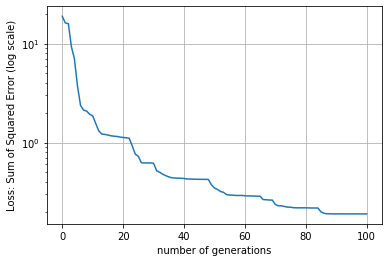

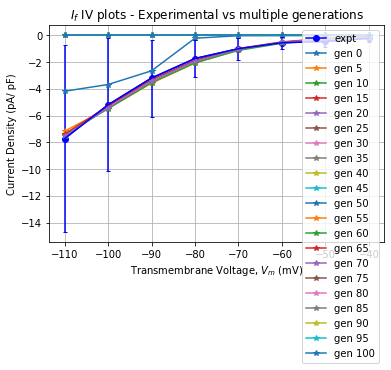

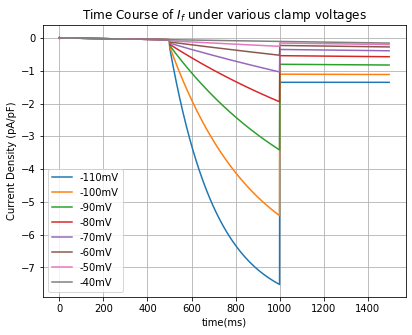

In [10]:
#If Genetic Algorithm Optimization - 100 generations
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()

V = np.arange(-110, -39, 10)

If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

# Population
# Parameter initialization: 10
C = np.empty((100, 10))
C[:, 0] = np.random.uniform(0, 1, C.shape[0])
C[:, 1] = np.random.uniform(0, 1, C.shape[0])
C[:, 2] = np.random.uniform(0, 3, C.shape[0])
C[:, 3] = np.random.uniform(70, 90, C.shape[0])
C[:, 4] = np.random.uniform(0, 10, C.shape[0])
C[:, 5] = np.random.uniform(0, 5, C.shape[0])
C[:, 6] = np.random.uniform(0, 1, C.shape[0])
C[:, 7] = np.random.uniform(0, 5, C.shape[0])
C[:, 8] = np.random.uniform(0, 1, C.shape[0])
C[:, 9] = np.random.uniform(3800, 4100, C.shape[0])


If_cur = np.empty((C.shape[0], len(V)))
population = C  # initial Population



# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        If_cur[i,:], time, plt_If = If_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9])

    SSE = np.sum(np.power((If_cur - If_act), 2, dtype=np.float64), axis=1)
    return SSE

def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = +99999999999
    return parents

def crossover(parents,
              offspring_size):  # double 
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gfk
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +      #gfna
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #ayss
                         (gene_select == 3)*np.random.uniform(-10, 10) +        #byss
                         (gene_select == 4)*np.random.uniform(-2, 2) +        #cyss
                         (gene_select == 5)*np.random.uniform(-1.5, 1.5) +          #a_ay
                         (gene_select == 6)*np.random.uniform(-0.01, 0.01) +      #b_ay
                         (gene_select == 7)*np.random.uniform(-1.5, 1.5) +      #a_by
                         (gene_select == 8)*np.random.uniform(-0.05, 0.05) +          #b_by
                         (gene_select == 9)*np.random.uniform(-50, 50)    #a_tau
                         )
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((8, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print(fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_If_fit = If_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, If_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('${I_f}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_If_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
#         plt.grid()
#         plt.show()

        i_plt = i_plt + 1
    
timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]


IfIni, time, IfIni_time = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)

Iffit, time, Iffit_time  = If_func(Best_Sol[0], Best_Sol[1], Best_Sol[2], Best_Sol[3],
 Best_Sol[4], Best_Sol[5], Best_Sol[6], Best_Sol[7], Best_Sol[8], Best_Sol[9])
If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

Vcm = np.arange(-110, -39, 10)

ini_r2 = r2_score(If_act, IfIni)
fit_r2 = r2_score(If_act, Iffit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IfIni_time
GA_trial_n.cur_time_fit = plt_If_fit
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IfIni

pickle.dump(GA_trial_n, open('If_GA_trial1.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)


plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error (log scale)')
plt.grid()
plt.show()

plt.figure()
plt.plot(V, If_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{f}$ IV plots - Experimental vs multiple generations')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5, 5))
plt.plot(time_fit, plt_If_fit)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_f$ under various clamp voltages')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()
plt.show()

**GA 2**

generation:  0
Runtime:  0.6711157166666453 mins
1.3304007858010867
generation:  5
Runtime:  3.8861500816666497 mins
0.5851531461073969
generation:  10
Runtime:  7.328885318333293 mins
0.25435320693377345
generation:  15
Runtime:  10.842144693333285 mins
0.22281631312644928
generation:  20
Runtime:  14.392514118333322 mins
0.1222863597981983
generation:  25
Runtime:  17.866409905 mins
0.06796761413167465
generation:  30
Runtime:  21.256415694999973 mins
0.043938478836089326
generation:  35
Runtime:  24.7328382633333 mins
0.02536468871723776
generation:  40
Runtime:  28.227697174999957 mins
0.022230016700229484
generation:  45
Runtime:  31.729217124999984 mins
0.021288209016640497
generation:  50
Runtime:  35.171504561666616 mins
0.021251769533721786
generation:  55
Runtime:  38.63385651666661 mins
0.021230032000413353
generation:  60
Runtime:  42.1717611833333 mins
0.02119988595366446
generation:  65
Runtime:  45.62980573666664 mins
0.021178925639558158
generation:  70
Runtime:  49.099

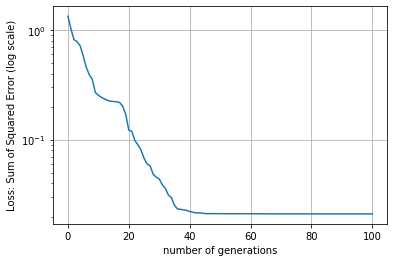

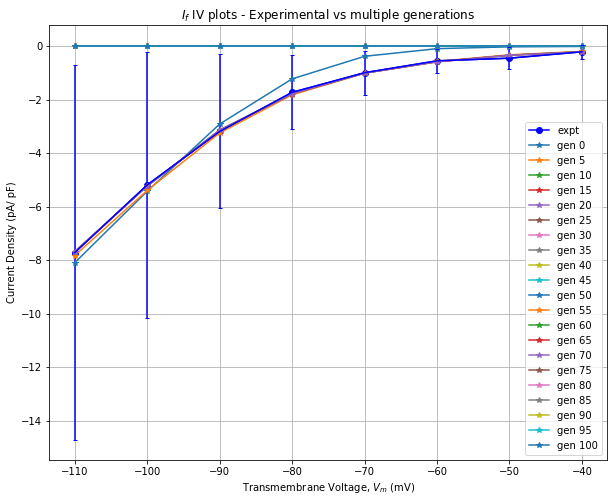

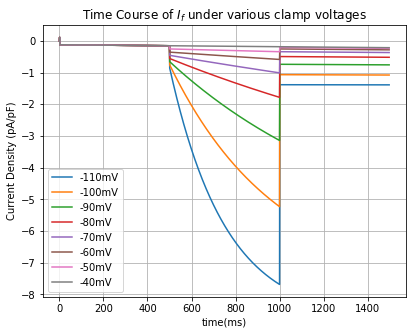

In [15]:
#If Genetic Algorithm Optimization - 100 generations
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()

V = np.arange(-110, -39, 10)

If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

# Population
# Parameter initialization: 10
C = np.empty((100, 10))
C[:, 0] = np.random.uniform(0, 1, C.shape[0])
C[:, 1] = np.random.uniform(0, 1, C.shape[0])
C[:, 2] = np.random.uniform(0, 3, C.shape[0])
C[:, 3] = np.random.uniform(70, 90, C.shape[0])
C[:, 4] = np.random.uniform(0, 10, C.shape[0])
C[:, 5] = np.random.uniform(0, 5, C.shape[0])
C[:, 6] = np.random.uniform(0, 1, C.shape[0])
C[:, 7] = np.random.uniform(0, 5, C.shape[0])
C[:, 8] = np.random.uniform(0, 1, C.shape[0])
C[:, 9] = np.random.uniform(3800, 4100, C.shape[0])


If_cur = np.empty((C.shape[0], len(V)))
population = C  # initial Population



# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        If_cur[i,:], time, plt_If = If_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9])

    SSE = np.sum(np.power((If_cur - If_act), 2, dtype=np.float64), axis=1)
    return SSE

def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = +99999999999
    return parents

def crossover(parents,
              offspring_size):  # double 
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gfk
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +      #gfna
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #ayss
                         (gene_select == 3)*np.random.uniform(-10, 10) +        #byss
                         (gene_select == 4)*np.random.uniform(-2, 2) +        #cyss
                         (gene_select == 5)*np.random.uniform(-1.5, 1.5) +          #a_ay
                         (gene_select == 6)*np.random.uniform(-0.01, 0.01) +      #b_ay
                         (gene_select == 7)*np.random.uniform(-1.5, 1.5) +      #a_by
                         (gene_select == 8)*np.random.uniform(-0.05, 0.05) +          #b_by
                         (gene_select == 9)*np.random.uniform(-50, 50)    #a_tau
                         )
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((8, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print(fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_If_fit = If_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, If_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('${I_f}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_If_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
#         plt.grid()
#         plt.show()

        i_plt = i_plt + 1
    
timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]


IfIni, time, IfIni_time = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)

Iffit, time, Iffit_time  = If_func(Best_Sol[0], Best_Sol[1], Best_Sol[2], Best_Sol[3],
 Best_Sol[4], Best_Sol[5], Best_Sol[6], Best_Sol[7], Best_Sol[8], Best_Sol[9])
If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

Vcm = np.arange(-110, -39, 10)

ini_r2 = r2_score(If_act, IfIni)
fit_r2 = r2_score(If_act, Iffit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IfIni_time
GA_trial_n.cur_time_fit = plt_If_fit
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IfIni

pickle.dump(GA_trial_n, open('If_GA_trial2.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)


plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error (log scale)')
plt.grid()
plt.show()

plt.figure(figsize = (10,8))
plt.plot(V, If_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{f}$ IV plots - Experimental vs multiple generations')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5, 5))
plt.plot(time_fit, plt_If_fit)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_f$ under various clamp voltages')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()
plt.show()

**GA 3**

generation:  0
Runtime:  0.6872304183333341 mins
4.539864656122206
generation:  5
Runtime:  4.077557773333335 mins
2.3076323526703977
generation:  10
Runtime:  7.485391775000001 mins
1.196398040054817
generation:  15
Runtime:  10.874381066666666 mins
1.0943101158869348
generation:  20
Runtime:  14.334159068333332 mins
0.8025694305322684
generation:  25
Runtime:  17.971360943333334 mins
0.7875391058153501
generation:  30
Runtime:  21.313623898333336 mins
0.7823696103628351
generation:  35
Runtime:  24.781029893333333 mins
0.7758460153235864
generation:  40
Runtime:  28.20527724 mins
0.7747842108829923
generation:  45
Runtime:  31.65008516833333 mins
0.6927839928286266
generation:  50
Runtime:  35.125981001666666 mins
0.6089895174822402
generation:  55
Runtime:  38.52286629333333 mins
0.5317620989588661
generation:  60
Runtime:  41.92085769833333 mins
0.48862306644799625
generation:  65
Runtime:  45.38346306833333 mins
0.46226088803298393
generation:  70
Runtime:  48.74118545333333 mins


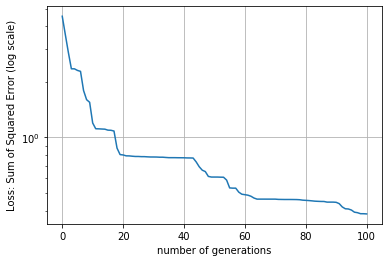

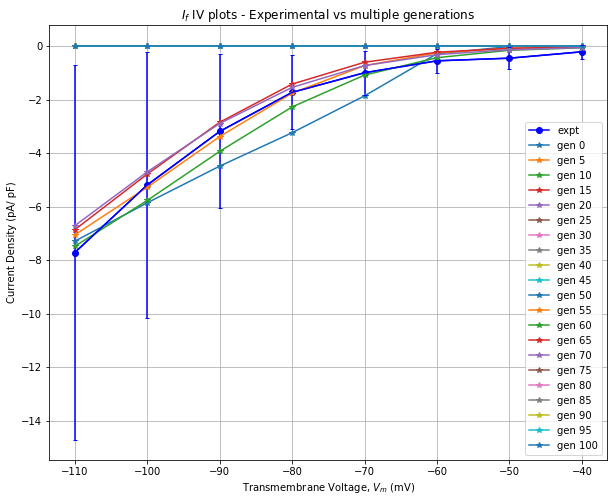

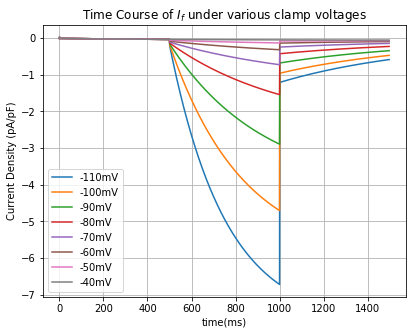

In [6]:
#If Genetic Algorithm Optimization - 100 generations
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()

V = np.arange(-110, -39, 10)

If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

# Population
# Parameter initialization: 10
C = np.empty((100, 10))
C[:, 0] = np.random.uniform(0, 1, C.shape[0])
C[:, 1] = np.random.uniform(0, 1, C.shape[0])
C[:, 2] = np.random.uniform(0, 3, C.shape[0])
C[:, 3] = np.random.uniform(70, 90, C.shape[0])
C[:, 4] = np.random.uniform(0, 10, C.shape[0])
C[:, 5] = np.random.uniform(0, 5, C.shape[0])
C[:, 6] = np.random.uniform(0, 1, C.shape[0])
C[:, 7] = np.random.uniform(0, 5, C.shape[0])
C[:, 8] = np.random.uniform(0, 1, C.shape[0])
C[:, 9] = np.random.uniform(3800, 4100, C.shape[0])


If_cur = np.empty((C.shape[0], len(V)))
population = C  # initial Population



# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        If_cur[i,:], time, plt_If = If_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9])

    SSE = np.sum(np.power((If_cur - If_act), 2, dtype=np.float64), axis=1)
    return SSE

def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = +99999999999
    return parents

def crossover(parents,
              offspring_size):  # double 
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gfk
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +      #gfna
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #ayss
                         (gene_select == 3)*np.random.uniform(-10, 10) +        #byss
                         (gene_select == 4)*np.random.uniform(-2, 2) +        #cyss
                         (gene_select == 5)*np.random.uniform(-1.5, 1.5) +          #a_ay
                         (gene_select == 6)*np.random.uniform(-0.01, 0.01) +      #b_ay
                         (gene_select == 7)*np.random.uniform(-1.5, 1.5) +      #a_by
                         (gene_select == 8)*np.random.uniform(-0.05, 0.05) +          #b_by
                         (gene_select == 9)*np.random.uniform(-50, 50)    #a_tau
                         )
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((8, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print(fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_If_fit = If_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, If_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('${I_f}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_If_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
#         plt.grid()
#         plt.show()

        i_plt = i_plt + 1
    
timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]


IfIni, time, IfIni_time = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)

Iffit, time, Iffit_time  = If_func(Best_Sol[0], Best_Sol[1], Best_Sol[2], Best_Sol[3],
 Best_Sol[4], Best_Sol[5], Best_Sol[6], Best_Sol[7], Best_Sol[8], Best_Sol[9])
If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

Vcm = np.arange(-110, -39, 10)

ini_r2 = r2_score(If_act, IfIni)
fit_r2 = r2_score(If_act, Iffit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IfIni_time
GA_trial_n.cur_time_fit = plt_If_fit
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IfIni

pickle.dump(GA_trial_n, open('If_GA_trial3.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)


plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error (log scale)')
plt.grid()
plt.show()

plt.figure(figsize = (10,8))
plt.plot(V, If_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{f}$ IV plots - Experimental vs multiple generations')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5, 5))
plt.plot(time_fit, plt_If_fit)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_f$ under various clamp voltages')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()
plt.show()

**GA 4**

generation:  0
Runtime:  0.7044755033332574 mins
1.60488470984345
generation:  5
Runtime:  4.248079358333295 mins
1.1403803063613098
generation:  10
Runtime:  7.735642966666637 mins
1.137841390444221
generation:  15
Runtime:  11.202577148333269 mins
1.0250069725098447
generation:  20
Runtime:  14.96253561333336 mins
0.6348404144214299
generation:  25
Runtime:  18.596117456666615 mins
0.6275003820005443
generation:  30
Runtime:  22.171390771666605 mins
0.5441188078038324
generation:  35
Runtime:  25.716115073333278 mins
0.43907187448925067
generation:  40
Runtime:  29.19075489 mins
0.4100102304205171
generation:  45
Runtime:  32.73451331333332 mins
0.3755063934887418
generation:  50
Runtime:  36.2420567066667 mins
0.36446833177085924
generation:  55
Runtime:  39.714537693333355 mins
0.35925476383798605
generation:  60
Runtime:  43.39999794166663 mins
0.3309289817588826
generation:  65
Runtime:  46.90108559 mins
0.3152253318854531
generation:  70
Runtime:  50.377170878333345 mins
0.30679

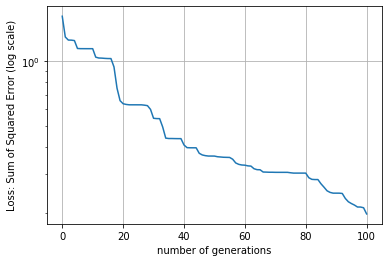

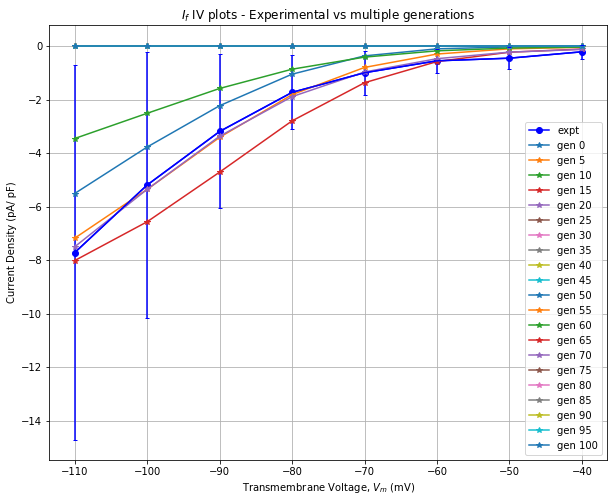

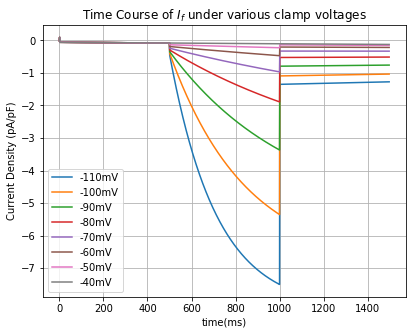

In [12]:
#If Genetic Algorithm Optimization - 100 generations
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()

V = np.arange(-110, -39, 10)

If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

# Population
# Parameter initialization: 10
C = np.empty((100, 10))
C[:, 0] = np.random.uniform(0, 1, C.shape[0])
C[:, 1] = np.random.uniform(0, 1, C.shape[0])
C[:, 2] = np.random.uniform(0, 3, C.shape[0])
C[:, 3] = np.random.uniform(70, 90, C.shape[0])
C[:, 4] = np.random.uniform(0, 10, C.shape[0])
C[:, 5] = np.random.uniform(0, 5, C.shape[0])
C[:, 6] = np.random.uniform(0, 1, C.shape[0])
C[:, 7] = np.random.uniform(0, 5, C.shape[0])
C[:, 8] = np.random.uniform(0, 1, C.shape[0])
C[:, 9] = np.random.uniform(3800, 4100, C.shape[0])


If_cur = np.empty((C.shape[0], len(V)))
population = C  # initial Population



# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        If_cur[i,:], time, plt_If = If_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9])

    SSE = np.sum(np.power((If_cur - If_act), 2, dtype=np.float64), axis=1)
    return SSE

def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = +99999999999
    return parents

def crossover(parents,
              offspring_size):  # double 
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gfk
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +      #gfna
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #ayss
                         (gene_select == 3)*np.random.uniform(-10, 10) +        #byss
                         (gene_select == 4)*np.random.uniform(-2, 2) +        #cyss
                         (gene_select == 5)*np.random.uniform(-1.5, 1.5) +          #a_ay
                         (gene_select == 6)*np.random.uniform(-0.01, 0.01) +      #b_ay
                         (gene_select == 7)*np.random.uniform(-1.5, 1.5) +      #a_by
                         (gene_select == 8)*np.random.uniform(-0.05, 0.05) +          #b_by
                         (gene_select == 9)*np.random.uniform(-50, 50)    #a_tau
                         )
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((8, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print(fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_If_fit = If_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, If_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('${I_f}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_If_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
#         plt.grid()
#         plt.show()

        i_plt = i_plt + 1
    
timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]


IfIni, time, IfIni_time = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)

Iffit, time, Iffit_time  = If_func(Best_Sol[0], Best_Sol[1], Best_Sol[2], Best_Sol[3],
 Best_Sol[4], Best_Sol[5], Best_Sol[6], Best_Sol[7], Best_Sol[8], Best_Sol[9])
If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

Vcm = np.arange(-110, -39, 10)

ini_r2 = r2_score(If_act, IfIni)
fit_r2 = r2_score(If_act, Iffit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IfIni_time
GA_trial_n.cur_time_fit = plt_If_fit
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IfIni

pickle.dump(GA_trial_n, open('If_GA_trial4.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)


plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error (log scale)')
plt.grid()
plt.show()

plt.figure(figsize = (10,8))
plt.plot(V, If_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{f}$ IV plots - Experimental vs multiple generations')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5, 5))
plt.plot(time_fit, plt_If_fit)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_f$ under various clamp voltages')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()
plt.show()

**GA 5**

generation:  0
Runtime:  0.8070222233333273 mins
4.730997646574408
generation:  5
Runtime:  4.561837763333309 mins
1.245492649076517
generation:  10
Runtime:  8.001579883333306 mins
0.9777028412477322
generation:  15
Runtime:  11.303713486666645 mins
0.7174418884362641
generation:  20
Runtime:  14.829554263333314 mins
0.6266263858339851
generation:  25
Runtime:  18.389420173333324 mins
0.5228338787295832
generation:  30
Runtime:  21.90881260833333 mins
0.4065384223157266
generation:  35
Runtime:  25.377685396666646 mins
0.2897743005093179
generation:  40
Runtime:  28.806577006666643 mins
0.16335812830503463
generation:  45
Runtime:  32.24043943999998 mins
0.14049575565928396
generation:  50
Runtime:  35.66049834166667 mins
0.12770796645295057
generation:  55
Runtime:  39.12195271166665 mins
0.12169516712161937
generation:  60
Runtime:  42.54024205333332 mins
0.104572884398545
generation:  65
Runtime:  45.89147328833333 mins
0.08430452616247479
generation:  70
Runtime:  49.2369838899999

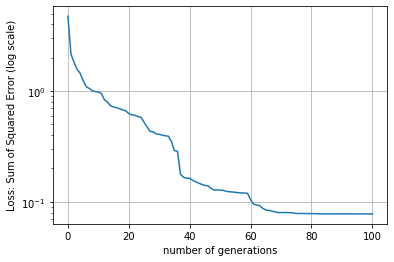

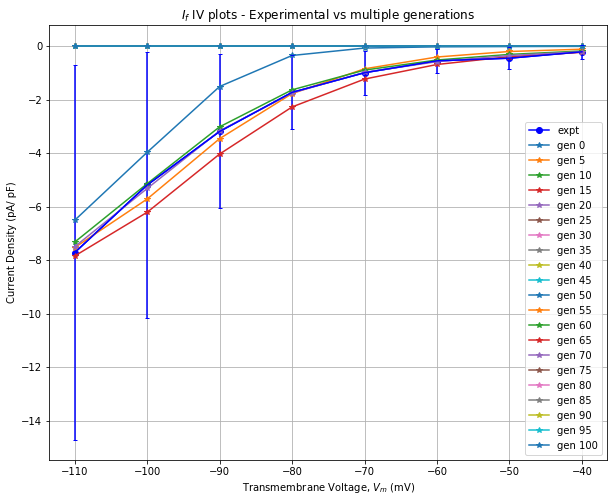

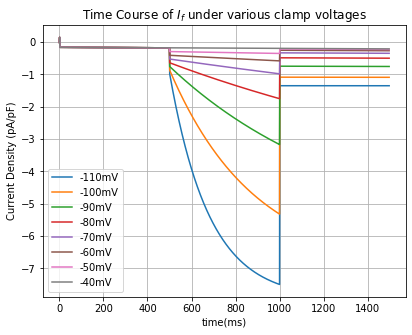

In [7]:
#If Genetic Algorithm Optimization - 100 generations
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()

V = np.arange(-110, -39, 10)

If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

# Population
# Parameter initialization: 10
C = np.empty((100, 10))
C[:, 0] = np.random.uniform(0, 1, C.shape[0])
C[:, 1] = np.random.uniform(0, 1, C.shape[0])
C[:, 2] = np.random.uniform(0, 3, C.shape[0])
C[:, 3] = np.random.uniform(70, 90, C.shape[0])
C[:, 4] = np.random.uniform(0, 10, C.shape[0])
C[:, 5] = np.random.uniform(0, 5, C.shape[0])
C[:, 6] = np.random.uniform(0, 1, C.shape[0])
C[:, 7] = np.random.uniform(0, 5, C.shape[0])
C[:, 8] = np.random.uniform(0, 1, C.shape[0])
C[:, 9] = np.random.uniform(3800, 4100, C.shape[0])


If_cur = np.empty((C.shape[0], len(V)))
population = C  # initial Population



# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        If_cur[i,:], time, plt_If = If_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9])

    SSE = np.sum(np.power((If_cur - If_act), 2, dtype=np.float64), axis=1)
    return SSE

def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = +99999999999
    return parents

def crossover(parents,
              offspring_size):  # double 
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gfk
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +      #gfna
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #ayss
                         (gene_select == 3)*np.random.uniform(-10, 10) +        #byss
                         (gene_select == 4)*np.random.uniform(-2, 2) +        #cyss
                         (gene_select == 5)*np.random.uniform(-1.5, 1.5) +          #a_ay
                         (gene_select == 6)*np.random.uniform(-0.01, 0.01) +      #b_ay
                         (gene_select == 7)*np.random.uniform(-1.5, 1.5) +      #a_by
                         (gene_select == 8)*np.random.uniform(-0.05, 0.05) +          #b_by
                         (gene_select == 9)*np.random.uniform(-50, 50)    #a_tau
                         )
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((8, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print(fit_val)
#         print(fitness)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_If_fit = If_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[indx, :])
#         plt.figure()
#         plt.plot(V, If_act, '-*', V, y_fit, '-o')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('${I_f}$ IV plot: Experimental vs Stewart Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure(figsize=(6.5, 5))
#         plt.plot(time_fit, plt_If_fit)
#         plt.xlabel('time(ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time Course of $I_f$ under various clamp voltages')
#         plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
#         plt.grid()
#         plt.show()

        i_plt = i_plt + 1
    
timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]


IfIni, time, IfIni_time = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)

Iffit, time, Iffit_time  = If_func(Best_Sol[0], Best_Sol[1], Best_Sol[2], Best_Sol[3],
 Best_Sol[4], Best_Sol[5], Best_Sol[6], Best_Sol[7], Best_Sol[8], Best_Sol[9])
If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

Vcm = np.arange(-110, -39, 10)

ini_r2 = r2_score(If_act, IfIni)
fit_r2 = r2_score(If_act, Iffit)

gen_num = np.arange(len(best_gen_fitness))

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = IfIni_time
GA_trial_n.cur_time_fit = plt_If_fit
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = IfIni

pickle.dump(GA_trial_n, open('If_GA_trial5.p', 'wb'))

print("Best Solution: ", Best_Sol)
print("Best solution fitness: ", final_fitness)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error (log scale)')
plt.grid()
plt.show()

plt.figure(figsize = (10,8))
plt.plot(V, If_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{f}$ IV plots - Experimental vs multiple generations')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, If_act, yerr=If_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5, 5))
plt.plot(time_fit, plt_If_fit)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_f$ under various clamp voltages')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()
plt.show()

Initial Model Goodness of fit, R_sq = -0.3642773505765353
GA fitted Model Goodness of fit, R_sq = 0.9984870584617149
percent change: [ 4.16093924e+03  5.22554552e+03  2.82228122e+02  6.04061501e+00
  1.35769241e+02 -9.72112195e+01 -4.60689045e+01  2.04416900e+02
  6.68799409e+01 -4.00950775e+00]


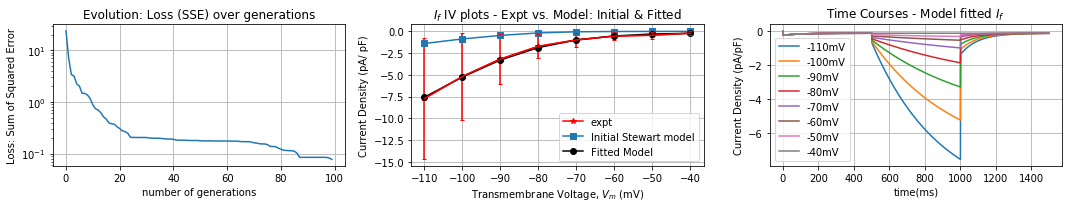

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

IfIni, time, IfIni_time = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)

Iffit, time, Iffit_time  = If_func(9.98534066e-01, 7.75687007e-01, 3.82228122e+00, 8.54687357e+01,
 1.60323084e+01, 8.08746343e-02, 2.15724382e-02, 1.09590084e+01,
 1.83567935e-01, 3.83961969e+03)
If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

Vcm = np.arange(-110, -39, 10)

ini_r2 = r2_score(If_act, IfIni)
fit_r2 = r2_score(If_act, Iffit)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

ini_param = np.array([0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000])
fin_param = np.array([9.98534066e-01, 7.75687007e-01, 3.82228122e+00, 8.54687357e+01,
 1.60323084e+01, 8.08746343e-02, 2.15724382e-02, 1.09590084e+01,
 1.83567935e-01, 3.83961969e+03])
percent_change = ((fin_param - ini_param)/ini_param)*100

print('percent change:', percent_change)

plt.figure(figsize= (15,3))
plt.subplot(1,3,3)
plt.plot(time, Iffit_time)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Courses - Model fitted $I_{f}$')
plt.legend(['-110mV', '-100mV', '-90mV', '-80mV', '-70mV', '-60mV', '-50mV', '-40mV'], loc='best')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Vcm, If_act, 'r-*', label = 'expt') #experimental plot
plt.plot(Vcm, IfIni, '-s', label='Initial Stewart model')  #initial model plot
plt.plot(Vcm, Iffit, 'k-o', label='Fitted Model') #modelfitted
plt.errorbar(Vcm, If_act, yerr=If_err, capsize=2, color = 'red') #errorbar experimental data
plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{f}$ IV plots - Expt vs. Model: Initial & Fitted')
plt.grid()
plt.legend(loc='best')

plt.subplot(1,3,1)
gen_num = np.arange(len(best_gen_fitness))
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.title('Evolution: Loss (SSE) over generations')
plt.grid()
plt.tight_layout()
plt.show()


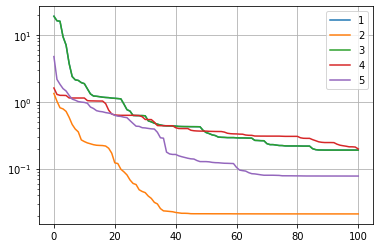

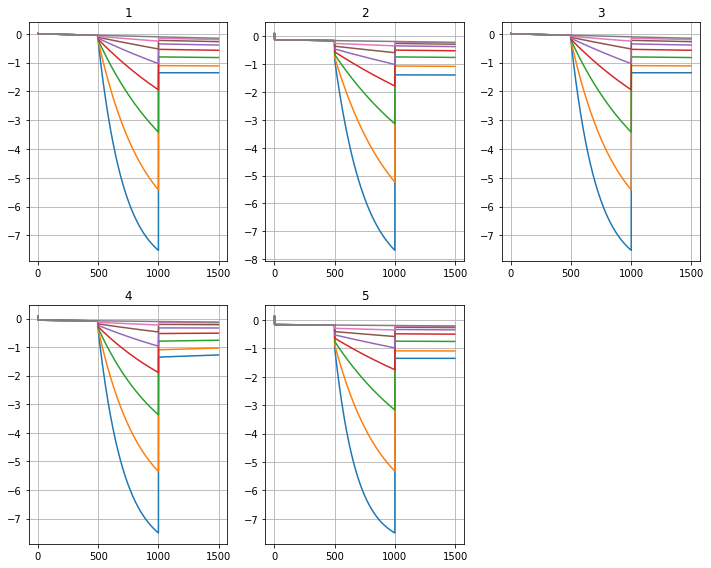

R_sq fit:  
[1] 0.996283163944078 
[2] 0.9995859520074227 
[3] 0.996283163944078 
[4] 0.9963126135878506 
[5] 0.9984776040728021

final_fitness:  
[1] 0.18973379424603679 
[2] 0.02113595957681943 
[3] 0.18973379424603679 
[4] 0.18823047460317271 
[5] 0.07771393498827034


In [3]:
import pickle
import matplotlib.pyplot as plt

# Creating a class to hold the trials data
import pickle

class GA_trial:
    gen_num = 0
    loss = 0
    R_sq_ini = 0
    R_sq_fin = 0
    Parameters = 0
    final_fit_Val = 0
    time = 0
    cur_time_fit = 0
    cur_time_ini = 0
    Vcm = 0
    I_peaks_fin = 0
    I_peaks_ini = 0
    

GA1 = pickle.load(open('If_GA_trial1.p', 'rb'))
GA2 = pickle.load(open('If_GA_trial2.p', 'rb'))
GA3 = pickle.load(open('If_GA_trial1.p', 'rb'))
GA4 = pickle.load(open('If_GA_trial4.p', 'rb'))
GA5 = pickle.load(open('If_GA_trial5.p', 'rb'))
plt.plot(GA1.gen_num, GA1.loss, label = '1')
plt.plot(GA2.gen_num, GA2.loss, label = '2')
plt.plot(GA3.gen_num, GA3.loss, label = '3')
plt.plot(GA4.gen_num, GA4.loss, label = '4')
plt.plot(GA5.gen_num, GA5.loss, label = '5')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize = (10,8))
plt.subplot(2,3,1)
plt.plot(GA1.time, GA1.cur_time_fit, label='1')
plt.title('1')
plt.grid()
plt.subplot(2,3,2)
plt.plot(GA2.time, GA2.cur_time_fit, label='2')
plt.title('2')
plt.grid()
plt.subplot(2,3,3)
plt.plot(GA3.time, GA3.cur_time_fit, label='3')
plt.title('3')
plt.grid()
plt.subplot(2,3,4)
plt.plot(GA4.time, GA4.cur_time_fit, label='4')
plt.title('4')
plt.grid()
plt.subplot(2,3,5)
plt.plot(GA5.time, GA5.cur_time_fit, label='5')
plt.title('5')
plt.grid()

plt.tight_layout()
plt.show()

print('R_sq fit: ', '\n[1]', GA1.R2_sq_fin, '\n[2]', GA2.R2_sq_fin, '\n[3]', GA3.R2_sq_fin, '\n[4]', GA4.R2_sq_fin, '\n[5]', GA5.R2_sq_fin)

print('\nfinal_fitness: ', '\n[1]', GA1.final_fit_val, '\n[2]', GA2.final_fit_val, '\n[3]', GA3.final_fit_val, '\n[4]', GA4.final_fit_val, '\n[5]', GA5.final_fit_val)

In [5]:
import numpy as np

If_trials_r2 = np.array([GA1.R2_sq_fin, GA2.R2_sq_fin, GA3.R2_sq_fin, GA4.R2_sq_fin, GA5.R2_sq_fin])
If_trials_fit = np.array([GA1.final_fit_val, GA2.final_fit_val, GA3.final_fit_val, GA4.final_fit_val, GA5.final_fit_val])

mean_r2 = np.mean(If_trials_r2)
stdv_r2 = np.std(If_trials_r2)

mean_fit = np.mean(If_trials_fit)
stdv_fit = np.std(If_trials_fit)

print('mean r2: ', mean_r2)
print('stdv r2: ', stdv_r2)
print('\n')

print('mean loss: ', mean_fit)
print('stdv loss: ', stdv_fit)

mean r2:  0.9973884995112462
stdv r2:  0.00138679559930143


mean loss:  0.13330959153206717
stdv loss:  0.07079192811852424


mean:  [-7.54451828 -5.34902577 -3.30290254 -1.86334183 -1.00687837 -0.53884286
 -0.28666234 -0.17264978]
stdv:  [0.07136023 0.0698344  0.12100521 0.08220813 0.02811167 0.04257894
 0.05098352 0.03499444]


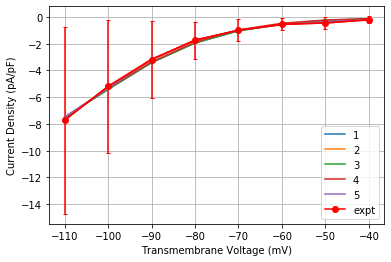

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#IfIni, time, IfIni_time = If_func(0.0234346, 0.0145654, 1, 80.6, 6.8, 2.9, 0.04, 3.6, 0.11, 4000)

# Iffit, time, Iffit_time  = If_func(9.98534066e-01, 7.75687007e-01, 3.82228122e+00, 8.54687357e+01,
#  1.60323084e+01, 8.08746343e-02, 2.15724382e-02, 1.09590084e+01,
#  1.83567935e-01, 3.83961969e+03)
If_act = np.array(
    [-7.719292191, -5.191894995, -3.191078509, -1.729348794, -0.995212502, -0.550478633, -0.451653444, -0.213560445])
If_err = np.array([7.004261908, 4.972815047, 2.878205575, 1.38609859, 0.816391, 0.443526266, 0.421838918, 0.266044595])

Vcm = np.arange(-110, -39, 10)

plt.plot(GA1.Vcm, GA1.I_peaks_fin, label='1')
plt.plot(GA2.Vcm, GA2.I_peaks_fin, label='2')
plt.plot(GA3.Vcm, GA3.I_peaks_fin, label='3')
plt.plot(GA4.Vcm, GA4.I_peaks_fin, label='4')
plt.plot(GA5.Vcm, GA5.I_peaks_fin, label='5')
plt.plot(Vcm, If_act, 'r-o', label='expt')
plt.errorbar(Vcm, If_act, yerr=If_err, capsize=2, color = 'red')
plt.xlabel('Transmembrane Voltage (mV)')
plt.ylabel('Current Density (pA/pF)')
plt.grid()
plt.legend()

If_GA_IV = np.zeros((5,len(GA1.I_peaks_fin)))
If_GA_IV[0,:] = GA1.I_peaks_fin
If_GA_IV[1,:] = GA2.I_peaks_fin
If_GA_IV[2,:] = GA3.I_peaks_fin
If_GA_IV[3,:] = GA4.I_peaks_fin
If_GA_IV[4,:] = GA5.I_peaks_fin


If_mean = np.mean(If_GA_IV, axis=0)
If_stdv = np.std(If_GA_IV, axis=0)
#print(If_GA_IV)
print('mean: ',If_mean)
print('stdv: ',If_stdv)

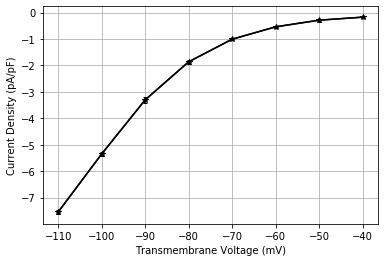

In [45]:
plt.figure()
# plt.figure(figsize=(10,8))
#plt.plot(Vcm, If_act, 'r-o', label='expt')
#plt.errorbar(Vcm, If_act, yerr=If_err, capsize=2, color = 'red')
plt.plot(Vcm, If_mean, 'k-*', label = 'Model(mean)')
plt.errorbar(Vcm, If_mean, yerr=If_stdv, capsize=2, color = 'black')
plt.grid()
plt.xlabel('Transmembrane Voltage (mV)')
plt.ylabel('Current Density (pA/pF)')
plt.show()

In [6]:
loss_ini = np.array([GA1.loss[0], GA2.loss[0], GA3.loss[0], GA4.loss[0], GA5.loss[0]])
loss_ini_mean = np.mean(loss_ini)
loss_ini_stdv = np.std(loss_ini)

print('initial losses: ', loss_ini)
print('mean initial loss: ', loss_ini_mean)
print('std initial loss: ', loss_ini_stdv)

initial losses:  [18.93159814  1.33040079 18.93159814  1.60488471  4.73099765]
mean initial loss:  9.105895885272025
std initial loss:  8.11112910726088


In [18]:
loss_fin = np.array([GA1.loss[-1], GA2.loss[-1], GA3.loss[-1], GA4.loss[-1], GA5.loss[-1]])
loss_fin_mean = np.mean(loss_fin)
loss_fin_stdv = np.std(loss_fin)

print('initial losses: ', loss_fin)
print('mean initial loss: ', loss_fin_mean)
print('std initial loss: ', loss_fin_stdv)

initial losses:  [0.18973389 0.02113627 0.18973389 0.1974227  0.07771788]
mean initial loss:  0.1351489244764365
std initial loss:  0.07229698283636334
